# Homework 4

This Notebook builds on the DCOPF model introduced in [Notebook 6](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks) and incorporates some elements of Economic Dispatch introduced in [Notebook 4](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks).

First, load (or install if necessary) a set of packages you'll need for this assignment...

In [1]:
using JuMP;             # optimisation
using GLPK;             # solver package
using DataFrames;       # data manipulation
using CSV;              # load in csv data
using Plots; plotly();  # base plots
using VegaLite;         # nice plots
using Query;            # dplyr like data analysis tools
using Statistics        # correlation operator

┌ Warning: ORCA.jl has been deprecated and all savefig functionality
│ has been implemented directly in PlotlyBase itself.
│ 
│ By implementing in PlotlyBase.jl, the savefig routines are automatically
│ available to PlotlyJS.jl also.
└ @ ORCA /Users/tombearpark/.julia/packages/ORCA/U5XaN/src/ORCA.jl:8


## Question 1: Modifying IEEE-14

**A. Increased generation costs**

Copy the IEEE 14 bus system and DCOPF solver function from Notebook 6. In addition, add the following line to the return call of the function:
```julia
status = termination_status(DCOPF)
```
This tells you the solver termination status for the problem: e.g. was an optimal solution found, was the solution infeasible, was it unbounded, etc.

Make the following change to the system:

- Increase the variable cost of Generator 1 to \$30 / MWh

Run the DCOPF and output generation, flows, and prices.

In [2]:
# Load and format the data

# Note - tweaked this to use an absolute path, since i'm writing this code 
# outside of the repo. Left in option for someone else to run it though
if ENV["USER"] == "tombearpark"
    pso_dir = "/Users/tombearpark/Documents/princeton/1st_year/MAE529/" *
                    "power-systems-optimization"
    datadir = joinpath(pso_dir,"Notebooks","ieee_test_cases") 
else
    datadir = joinpath("..","Notebooks","ieee_test_cases") 
end


gens = CSV.read(joinpath(datadir,"Gen14.csv"), DataFrame);
lines = CSV.read(joinpath(datadir,"Tran14.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Load14.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gens, lines, loads]
    rename!(f,lowercase.(names(f)))
end

# create generator ids 
gens.id = 1:nrow(gens);

# create line ids 
lines.id = 1:nrow(lines);
# add set of rows for reverse direction with same parameters
lines2 = copy(lines)
lines2.f = lines2.fromnode
lines2.fromnode = lines.tonode
lines2.tonode = lines2.f
lines2 = lines2[:,names(lines)]
append!(lines,lines2)

# calculate simple susceptance, ignoring resistance as earlier 
lines.b = 1 ./ lines.reactance

# keep only a single time period
loads = loads[:,["connnode","interval-1_load"]]
rename!(loads,"interval-1_load" => "demand");

In [3]:
#=
# Copy the IEEE 14 bus system and DCOPF solver function from Notebook 6.
# In addition, add the following line to the return call of the function:
# status = termination_status(DCOPF)

Function to solve DC OPF problem using IEEE test cases
Inputs:
    gen_info -- dataframe with generator info
    line_info -- dataframe with transmission lines info
    loads  -- dataframe with load info
=#
function dcopf_ieee(gens, lines, loads)
    DCOPF = Model(GLPK.Optimizer) # You could use Clp as well, with Clp.Optimizer
    
    # Define sets based on data
      # Set of generator buses
    G = gens.connnode
    
      # Set of all nodes
    N = sort(union(unique(lines.fromnode), 
            unique(lines.tonode)))
    
      # sets J_i and G_i will be described using dataframe indexing below

    # Define per unit base units for the system 
    # used to convert from per unit values to standard unit
    # values (e.g. p.u. power flows to MW/MVA)
    baseMVA = 100 # base MVA is 100 MVA for this system
    
    # Decision variables   
    @variables(DCOPF, begin
        GEN[N]  >= 0     # generation        
        # Note: we assume Pmin = 0 for all resources for simplicty here
        THETA[N]         # voltage phase angle of bus
        FLOW[N,N]        # flows between all pairs of nodes
    end)
    
    # Create slack bus with reference angle = 0; use bus 1 with generator
    fix(THETA[1],0)
                
    # Objective function
    @objective(DCOPF, Min, 
        sum( gens[g,:c1] * GEN[g] for g in G)
    )
    
    # Supply demand balances
    @constraint(DCOPF, cBalance[i in N], 
        sum(GEN[g] for g in gens[gens.connnode .== i,:connnode]) 
            + sum(load for load in loads[loads.connnode .== i,:demand]) 
        == sum(FLOW[i,j] for j in lines[lines.fromnode .== i,:tonode])
    )

    # Max generation constraint
    @constraint(DCOPF, cMaxGen[g in G],
                    GEN[g] <= gens[g,:pgmax])

    # Flow constraints on each branch; 
    # In DCOPF, line flow is a function of voltage angles
       # Create an array of references to the line constraints, 
       # which we "fill" below in loop
    cLineFlows = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 
    for l in 1:nrow(lines)
        cLineFlows[l] = @constraint(DCOPF, 
            FLOW[lines[l,:fromnode],lines[l,:tonode]] == 
            baseMVA * lines[l,:b] * 
            (THETA[lines[l,:fromnode]] - THETA[lines[l,:tonode]])
        )
    end
    
    # Max line flow limits
       # Create an array of references to the line constraints, 
       # which we "fill" below in loop
    cLineLimits = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 
    for l in 1:nrow(lines)
        cLineLimits[l] = @constraint(DCOPF,
            FLOW[lines[l,:fromnode],lines[l,:tonode]] <=
            lines[l,:capacity]
        ) 
    end

    # Solve statement (! indicates runs in place)
    optimize!(DCOPF)

    # Output variables
    generation = DataFrame(
        node = gens.connnode,
        gen = value.(GEN).data[gens.connnode]
        )
    
    angles = value.(THETA).data
    
    flows = DataFrame(
        fbus = lines.fromnode,
        tbus = lines.tonode,
        flow = baseMVA * lines.b .* (angles[lines.fromnode] .- 
                        angles[lines.tonode]))
    
    # We output the marginal values of the demand constraints, 
    # which will in fact be the prices to deliver power at a given bus.
    prices = DataFrame(
        node = N,
        value = dual.(cBalance).data)
    
    # Return the solution and objective as named tuple
    return (
        generation = generation, 
        angles,
        flows,
        prices,
        cost = objective_value(DCOPF),
        status = termination_status(DCOPF)
    )
end

dcopf_ieee (generic function with 1 method)

In [4]:
# helper function for printing cost info
# input: solution: an optimised JuMP object

function print_cost_and_status(solution)
    println("Termination status was " * string(solution.status))
    println("Optimised cost was " * string(round(solution.cost)))
end

print_cost_and_status (generic function with 1 method)

In [5]:
# First - run the model with baseline numbers to get a comparison

solution = dcopf_ieee(gens, lines, loads);
print_cost_and_status(solution)

Termination status was OPTIMAL
Optimised cost was 5180.0


In [6]:
# Now - Problem 1a)

# Make the following change to the system:
# Increase the variable cost of Generator 1 to $30 / MWh
# Run the DCOPF and output generation, flows, and prices.

# Increase the variable cost of generator 1
gens_1a = copy(gens) 
gens_1a.c1[gens_1a.id .==1] .= 30

solution_1a = dcopf_ieee(gens_1a, lines, loads);
print_cost_and_status(solution_1a)

Termination status was OPTIMAL
Optimised cost was 6370.0


In [7]:
# Compare generation across models 

gen_comparison_df = DataFrame(
    baseline = solution.generation.gen, 
    increased_price_scen = solution_1a.generation.gen)

,baseline,increased_price_scen
,Float64,Float64
1,119.0,119.0
2,140.0,140.0


In [8]:
# Compare flows across models
flow_comparison_df = DataFrame(
    baseline = solution.flows.flow, 
    increased_price_scen = solution_1a.flows.flow);
head(flow_comparison_df)

,baseline,increased_price_scen
,Float64,Float64
1,64.0779,64.0779
2,54.9221,54.9221
3,72.7846,72.7846
4,60.9488,60.9488
5,48.6446,48.6446
6,-21.4154,-21.4154


In [9]:
# Compare prices across models
price_comparison_df = DataFrame(
    baseline = solution.prices.value, 
    increased_price_scen = solution_1a.prices.value)

,baseline,increased_price_scen
,Float64,Float64
1,20.0,30.0
2,20.0,30.0
3,20.0,30.0
4,20.0,30.0
5,20.0,30.0
6,20.0,30.0
7,20.0,30.0
8,20.0,30.0
9,20.0,30.0


Regarding the above results, answer the following:

- How has generation changed compared to the default system?
- What explains the new prices?


##### Generation
- Generation has not changed at all relative to the default system.
    - This is because we still have the total amount of demand on the system, and have not
    introduced any losses or anything that affects the supply / demand constraint.
    - Therefore, the change in prices just increases the costs of supplying the system, 
    without affecting the total amount of energy supplied. 
    
##### Prices
- We find that prices are uniformly increased in this new scenario from 20 dollars per MWh to 30 dollars per MWh. 
- This reflects that fact that the generator for which we increased the price
was the marginal generator. 
- Therefore, increases in its price are reflected in system prices. 

**B. Constrained line**

Make the following changes to the system:

- Increase the variable cost of Generator 1 to \$30 / MWh
- Reduce flow limit on the line connecting 2 and 3 ($l_{23}$) to 70 MW

Run the DCOPF and output generation, flows, and prices.

In [10]:
# We can use the same generation info as in 1A

# Reduce the flow limit on line connecting 2 and 3...
lines_1b = copy(lines)
lines_1b.capacity[(lines_1b.fromnode .== 2).&(lines_1b.tonode .== 3)] .= 70
lines_1b.capacity[(lines_1b.fromnode .== 3).&(lines_1b.tonode .== 2)] .= 70;

In [11]:
# Solve - and print solution
solution_1b = dcopf_ieee(gens_1a, lines_1b, loads);
print_cost_and_status(solution_1b)

Termination status was OPTIMAL
Optimised cost was 7388.0


In [12]:
# output generation, flows, and prices
gen_comparison_df.inc_price_and_flow_const = solution_1b.generation.gen
gen_comparison_df

,baseline,increased_price_scen,inc_price_and_flow_const
,Float64,Float64,Float64
1,119.0,119.0,220.837
2,140.0,140.0,38.1627


In [13]:
flow_comparison_df.inc_price_and_flow_const = solution_1b.flows.flow
head(flow_comparison_df)

,baseline,increased_price_scen,inc_price_and_flow_const
,Float64,Float64,Float64
1,64.0779,64.0779,149.42
2,54.9221,54.9221,71.417
3,72.7846,72.7846,70.0
4,60.9488,60.9488,55.1212
5,48.6446,48.6446,40.7618
6,-21.4154,-21.4154,-24.2


In [14]:
price_comparison_df.inc_price_and_flow_const = solution_1b.prices.value
head(price_comparison_df)

,baseline,increased_price_scen,inc_price_and_flow_const
,Float64,Float64,Float64
1,20.0,30.0,30.0
2,20.0,30.0,20.0
3,20.0,30.0,224.574
4,20.0,30.0,85.3586
5,20.0,30.0,67.6948
6,20.0,30.0,73.7014


Regarding the above results, answer the following:

- Which node has the highest price and why?
- What is the difference in prices across $l_{23}$, also known as the congestion rent? How do you interpret this value (what is it's practical meaning?)

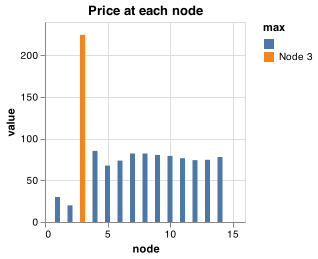

In [15]:
solution_1b.prices.max = ""
solution_1b.prices.max[
    solution_1b.prices.value .== maximum(solution_1b.prices.value)] .= "Node 3"
solution_1b.prices |>
    @vlplot(:bar, x = :node, y = :value, color = :max, title = "Price at each node")

##### Which node has the highest price and why?
- As we can see from the above plot, Node 3 has the highest price, by a long way. 
- This reflects the there is a lot of congestion at this node, and therefore
the marginal cost of increasing supply at this node is very high. 
- Given the physics of the system, increasing the load at node 3 would require significant
extra generation (ie more than just the additional load). 

In [16]:
cong_rest = solution_1b.prices.value[solution_1b.prices.node .== 3][1]  - 
    solution_1b.prices.value[solution_1b.prices.node .== 2][1]

204.57409253798673

##### What is the difference in prices across $l_{23}$, also known as the congestion rent? How do you interpret this value (what is it's practical meaning?)
- The difference in prices across node 2 and 3 is more than 200 dollars per MWh. 
- I interpret this as being the additional cost required to supply an extra unit of 
energy at node 3 compared to at node 2. This is due to the congestion at node 3.
- It would reduce costs a lot to move future extra demand to node 2 rather than node 3, to reduce the congestion rent to the system.

**C. Demand increase**

Make the following changes to the system:

- Increase the variable cost of Generator 1 to \$30 / MWh
- Reduce flow limit on the line connecting 2 and 3 ($l_{23}$) to 70 MW
- Increase demands everywhere by 5\%.

In [17]:
# Increase demands everywhere by 5%

loads_1c = copy(loads) |>
    @mutate(demand = _.demand * 1.05) |>
    DataFrame

,connnode,demand
,Int64,Float64
1,2,-22.785
2,3,-98.91
3,4,-50.19
4,5,-7.98
5,6,-11.76
6,9,-30.975
7,10,-9.45
8,11,-3.675
9,12,-6.405


Calculate the total available generating capacity:

In [18]:
total_capacity = sum(gens_1a.pgmax)

472.4

Calculate the new total demand:

In [19]:
total_demand = -sum(loads_1c.demand)

271.94999999999993

Run the DCOPF and show prices.

In [42]:
solution_1c = dcopf_ieee(gens_1a, lines_1b, loads_1c);
string(solution_1c.status)

"INFEASIBLE"

In [21]:
solution_1c.prices

,node,value
,Int64,Float64
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
5,5,NaN
6,6,NaN
7,7,NaN
8,8,NaN
9,9,1.0


**What is happening in this system?** 

- We cannot meet demand, given the constraints on our system 
- Despite us having enough available generation, we can't get it to the demand in a feasible way, given the physics of the system. 
- Therefore, prices are NaN (we can think of this as being infinite). 

## Question 2: Linear losses

Up until now, we have ignored transmission losses. A quadratic approximation of losses is given by:
$$
\begin{align}
LOSS_{ij} &\approx \frac{G_{ij}}{BaseMVA} (\theta_i-\theta_j)^2 \\
 & \approx \frac{1}{BaseMVA} \frac{R_{ij}}{R_{ij}^2+X_{ij}^2}(\theta_i-\theta_j)^2
\end{align}
$$

where $G$ is the line's conductance, $R$ is the line's resistance and $X$ is the line's reactance. See the `lines` data frame for these parameters.

For our purposes, we will approximate this quadratic via:


$$
LOSS_{ij} \geq \frac{R_{ij}}{BaseMVA} \times (MaxFlow_{ij})^2 
\left(\frac{|FLOW_{ij}|}{MaxFlow_{ij}} - 0.165 \right)
$$

where $MaxFlow_{ij}=200 MW$ in this problem. Note the greater than equal sign, as we do not want to have negative losses.

This approximation is based on Fitiwi et al. (2016), "Finding a representative network losses model for large-scale transmission expansion planning with renewable energy sources," *Energy* 101: 343-358, https://doi.org/10.1016/j.energy.2016.02.015. 

Note that this is a linear approximation of transmission losses, which are actually a quadratic function of power flows. Fitiwi et al. 2016 and other papers describe piece-wise or segment-wise linear approximations of the quadratic function which provide a tighter lower bound approximation of losses, but we'll use a single linear term for this assignment. 

See Jenkins & Sepulveda et al. 2017, "Enhanced decision support for a changing electricity landscape: the GenX configurable electricity resource capacity expansion model", MIT Energy Initiative Working Paper 2017-10 http://bit.ly/GenXModel Section 5.8, for an example of a linear segment-wise approximation of quadratic transmission losses. 


**A. Code linear losses**

Reload the original data from Notebook 6 and copy the IEEE 14 bus system and DCOPF solver function from Notebook 6 into a new function `dcopf_ieee_lossy`.

Make the following changes:
- Increase the variable cost of Generator 1 to \$30 / MWh
- Change all transmission line capacities to 200 MW

Implement losses into the supply/demand balance equations. A standard way to implement absolute values in linear programming is by introducing two non-negative auxiliary variables $x^+$, $x^-$ $\geq 0$:

$$
x = x^+ - x^-
$$

and the absolute value can be represented as:

$$
|x| = x^+ + x^-
$$

(You should satisfy yourself that this equality holds.)

It makes the formulation easier if losses are added to the supply/demand balance constraint in each node by splitting losses in half between the receiving and sending end.

Indicate which equations and variables you have added and explain your steps using inline code comments (e.g. `# Comment`).

Run the lossy DCOPF and output generation, flows, losses, and prices.

In [22]:
#=
Function to solve DC OPF problem using IEEE test cases. Includes quadratic 
loss approximation 
Inputs:
    gen_info -- dataframe with generator info
    line_info -- dataframe with transmission lines info
    loads  -- dataframe with load info
=#
function dcopf_ieee_lossy(gens, lines, loads)

    DCOPF = Model(GLPK.Optimizer) # You could use Clp as well, with Clp.Optimizer
    G = gens.connnode
      # Set of all nodes
    N = sort(union(unique(lines.fromnode), 
            unique(lines.tonode)))
    baseMVA = 100 # base MVA is 100 MVA for this system
    
    # Decision variables   
    @variables(DCOPF, begin
        GEN[N]  >= 0     # generation        
        # Note: we assume Pmin = 0 for all resources for simplicty here
        THETA[N]         # voltage phase angle of bus
        FLOW[N,N]        # flows between all pairs of nodes
        # Include auxilliary variable - to get absolute value
        FLOW_abs[N,N] >= 0
    end)

    # Constraint for Flow variables - constrain the absolute value version
    # borrowing idea from here: 
    # https://github.com/jump-dev/JuMP.jl/issues/48#issuecomment-25575389
    cAbs_Flows_neg = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 
    cAbs_Flows_pos = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 

    for l in 1:nrow(lines)
        cAbs_Flows_neg[l] = @constraint(
            DCOPF, 
            FLOW_abs[lines[l,:fromnode],lines[l,:tonode]] >= 
            - FLOW[lines[l,:fromnode],lines[l,:tonode]]  
            )        
        cAbs_Flows_pos[l] = @constraint(
            DCOPF, 
            FLOW_abs[lines[l,:fromnode],lines[l,:tonode]] >= 
            FLOW[lines[l,:fromnode],lines[l,:tonode]]  
            )        
    end

    # Create slack bus with reference angle = 0; use bus 1 with generator
    fix(THETA[1],0)
                
    # Objective function
    @objective(DCOPF, Min, 
        sum( gens[g,:c1] * GEN[g] for g in G)
    )
    
    # Set the max flow - erroring if we aren't in the simple sitution defined 
    # in this particular problem
    if length(unique(lines.capacity)) .== 1
        MaxFlow = maximum(lines.capacity)
    else
        throw(DomainError("Only coded it up for homogenous max flow"))
    end

    # expression for losses
    eLoss = JuMP.Containers.DenseAxisArray{Any}(undef, 1:length(N), 1:length(N)) 
    # fill with zeros - for where we dont have any lines
    fill!(eLoss, 0)
    for l in 1:nrow(lines)
        eLoss[lines.fromnode[l], lines.tonode[l]] = @expression(DCOPF, 
            (lines.resistance[l] ./
                baseMVA) .* (MaxFlow ^ 2) .*
                (
                (FLOW_abs[lines.fromnode[l],lines.tonode[l]] 
                    ./ MaxFlow) .- 0.165
                )
        )
    end

    # Make sure losses are never negative
    @constraint(DCOPF, 
        eLoss_pos[l in 1:nrow(lines)], 
        eLoss[lines.fromnode[l], lines.tonode[l]] >=0
        )

    # Supply demand balances - add in losses expression
    # split losses as being half for each direction, for coding convenience
    @constraint(DCOPF, 
        cBalance[i in N], 
        sum(GEN[g] for g in gens[gens.connnode .== i,:connnode]) 
            + sum(load for load in loads[loads.connnode .== i,:demand]) 
        == sum(FLOW[i,j] + 0.5 * eLoss[i, j]
            for j in lines[lines.fromnode .== i,:tonode]) 
    )

    # Max generation constraint
    @constraint(DCOPF, cMaxGen[g in G],
                    GEN[g] <= gens[g,:pgmax])

    # Flow constraints on each branch; 
    # In DCOPF, line flow is a function of voltage angles
       # Create an array of references to the line constraints, 
       # which we "fill" below in loop
    cLineFlows = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 
    for l in 1:nrow(lines)
        cLineFlows[l] = @constraint(DCOPF, 
            FLOW[lines[l,:fromnode],lines[l,:tonode]] == 
            baseMVA * lines[l,:b] * 
            (THETA[lines[l,:fromnode]] - THETA[lines[l,:tonode]])
        )
    end
    
    # Max line flow limits
       # Create an array of references to the line constraints, 
       # which we "fill" below in loop
    cLineLimits = JuMP.Containers.DenseAxisArray{Any}(undef, 1:nrow(lines)) 
    for l in 1:nrow(lines)
        cLineLimits[l] = @constraint(DCOPF,
            FLOW[lines[l,:fromnode],lines[l,:tonode]] <=
            lines[l,:capacity]
        ) 
    end

    # Solve statement (! indicates runs in place)
    optimize!(DCOPF)

    # Output variables
    generation = DataFrame(
        node = gens.connnode,
        gen = value.(GEN).data[gens.connnode]
        )
    
    angles = value.(THETA).data
    
    flows = DataFrame(
        fbus = lines.fromnode,
        tbus = lines.tonode,
        flow = baseMVA * lines.b .* (angles[lines.fromnode] .- 
                        angles[lines.tonode]))
    
    # We output the marginal values of the demand constraints, 
    # which will in fact be the prices to deliver power at a given bus.
    prices = DataFrame(
        node = N,
        value = dual.(cBalance).data)

    # Return the solution and objective as named tuple
    return (
        generation = generation, 
        angles,
        flows,
        prices,
        cost = objective_value(DCOPF),
        status = termination_status(DCOPF),
        flows_raw = DataFrame(value.(FLOW).data),
        flows_raw_abs = DataFrame(value.(FLOW_abs).data),
        losses = DataFrame(
            node = N,
            associated_loss = value.(eLoss_pos)[1:length(N)])
    )
end


dcopf_ieee_lossy (generic function with 1 method)

In [23]:
# Increase the variable cost of Generator 1 to $30 / MWh
#  we use gens_1a dataframe, which already has that

# Change all transmission line capacities to 200 MW
lines_2 = copy(lines)
lines_2.capacity .= 200;


In [24]:
# Approximate the quadratic
# Current version runs, with no changes 
solution_2 = dcopf_ieee_lossy(gens_1a, lines_2, loads);
print_cost_and_status(solution_2)

Termination status was OPTIMAL
Optimised cost was 6790.0


In [25]:
# output generation
solution_2.generation

,node,gen
,Int64,Float64
1,1,132.987
2,2,140.0


In [26]:
# output flows
solution_2.flows 

,fbus,tbus,flow
,Int64,Int64,Float64
1,1,2,72.9149
2,1,5,57.9503
3,2,3,74.2381
4,2,4,62.1111
5,2,5,49.5219
6,3,4,-21.8997
7,4,5,-55.5821
8,4,7,29.2291
9,4,9,16.7713


In [27]:
# output losses
solution_2.losses

,node,associated_loss
,Int64,Float64
1,1,2.82618
2,2,6.26211
3,3,6.9769
4,4,7.21855
5,5,5.64054
6,6,4.42266
7,7,1.48404
8,8,0.0
9,9,0.0


In [28]:
# output prices
solution_2.prices

,node,value
,Int64,Float64
1,1,30.0
2,2,31.0351
3,3,34.4923
4,4,34.8189
5,5,34.0158
6,6,34.2889
7,7,34.6749
8,8,34.6749
9,9,34.5992


**B. Interpret results**

Run the same parameters in the lossless OPF from problem 1. How do prices and flows change? What is the largest magnitude difference in prices between the solution with losses and the lossless OPF solution?

In [29]:
# Compare to without the losses
# Run the same parameters in the lossless OPF from problem 1. 
# How do prices and flows change? What is the largest magnitude 
# difference in prices between the solution with losses 
# and the lossless OPF solution?

solution_2_no_losses = dcopf_ieee(gens_1a, lines_2, loads);
print_cost_and_status(solution_2_no_losses)

Termination status was OPTIMAL
Optimised cost was 6370.0


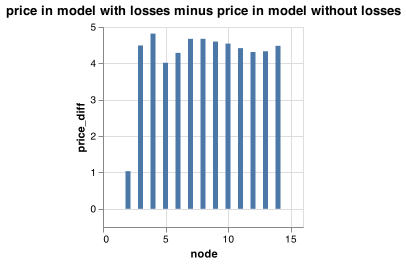

In [30]:
# Plot a comparison of the prices 
comp_price_df = DataFrame(with_losses = solution_2.prices.value, 
    without_losses = solution_2_no_losses.prices.value)
comp_price_df.price_diff = comp_price_df.with_losses .- comp_price_df.without_losses
comp_price_df.node = 1:14
comp_price_df |>
    @vlplot(:bar, x = :node, y = :price_diff, title = "price in model with losses minus price in model without losses")

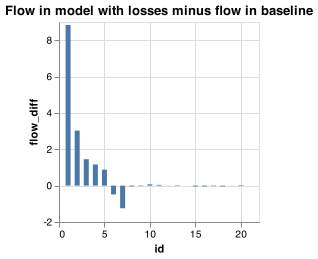

In [31]:
# Comparison of flows
# Include only one direction differences, since they are just mirror images
comp_loss_df = DataFrame(with_losses = solution_2.flows.flow[1:20], 
    without_losses = solution_2_no_losses.flows.flow[1:20])
comp_loss_df.flow_diff = comp_loss_df.with_losses .- comp_loss_df.without_losses
comp_loss_df.id = 1:20
comp_loss_df |>
    @vlplot(:bar, x = :id, y = :flow_diff, 
    title = "Flow in model with losses minus flow in baseline")


In [32]:
# Check the correlation between levels of flow and losses

scatter(solution_2.flows.flow[1:20], comp_loss_df.flow_diff, label = "lines")
xaxis!("Level of flow in solution with losses")
yaxis!("Change in flow compared to baseline")

<!DOCTYPE html>
 
 
 Plots.jl

In [33]:
# Check correlation statistic - its high and positive
cor(solution_2.flows.flow[1:20], comp_loss_df.flow_diff)

0.6521689436638195

#### How do prices and flows change? What is the largest magnitude difference in prices between the solution with losses and the lossless OPF solution?
- Losses increase the system prices at all nodes, except node 1 where they are unnafacted
    - They are not affected at node 1, because this getting extra generation here 
    doesn't require transporting energy across more lines, and therefore doesn't 
    incurr any losses. 
    - Prices increase due to the additional generation required to meet the losses as well
as the demand. We can think of this change as increasing the net demand of the system. 
- The largest magnitude in price difference is at node 4. 
    - This reflects the high losses experiened in getting load to node, and the associated congestion rents. 
- The biggest changes in flows are associated with lines that have large magnitudes of flow.
    - This is because losses are an increasing function of the absolute value of flow. 

## Question 3 - Security contingencies

Power system operators need to ensure that power is delivered reliably even in the event of unexpected outages (**contingencies**). One common contigency that must be planned for is the loss of a transmission line. The security-constrained OPF (SCOPF) run by operators solves for an optimal dispatch that is simultaneously robust (i.e., feasible) to each of the lines failing individually. This is what is known as **N-1 security**, because we assume that at most one component fails in any given scenario.

In this problem, we will not code a full SCOPF, but rather investigate what happens to the feasibility of our problem when we remove transmission lines.

**A. Setup data**

The following code loads the original dataset (with one row per line) and includes a function `format_lines` that converts this to a format that our solver function can use (duplicating rows for both directions, adding susceptance, etc.).

In [34]:
lines = CSV.read(joinpath(datadir,"Tran14.csv"), DataFrame);
rename!(lines,lowercase.(names(lines)))

function format_lines(lines)
    # create line ids 
    lines.id = 1:nrow(lines);
    # add set of rows for reverse direction with same parameters
    lines2 = copy(lines)
    lines2.f = lines2.fromnode
    lines2.fromnode = lines.tonode
    lines2.tonode = lines2.f
    lines2 = lines2[:,names(lines)]
    append!(lines,lines2)

    # calculate simple susceptance, ignoring resistance as earlier 
    lines.b = 1 ./ lines.reactance
    return(lines)
end

format_lines (generic function with 1 method)

Next:

1. Set the capacity of all lines in the system at 100 MW, except for the line $l_{12}$, which you should set to 200 MW.

2. Create a load dataframe `loads_sens` that increases demands everywhere by 10\%

In [35]:
# 1. Set the capacity of all lines in the system at 100 MW, 
# except for the line $l_{12}$, which you should set to 200 MW.
lines.capacity = 100
lines.capacity[(lines.fromnode .== 1).&(lines.tonode .== 2)] .= 200;

In [36]:
# 2. Create a load dataframe loads_sens that increases demands everywhere by 10%
loads_sens = copy(loads) |>
    @mutate(demand = _.demand * 1.1) |>
    DataFrame;

**B. Loop over line contingencies**

Create a dataframe `status` with the `fromnode` and `tonode` columns of `lines`.

Create a [for loop](https://docs.julialang.org/en/v1/manual/control-flow/#man-loops) that iterates over each line and:
- sets the reactance to be a very high value, 1e9 (i.e., no power will be transmitted)
- creates a version of the dataframe that our solver function can use via `format_lines`
- runs DCOPF
- stores the solution status in a `opf` column in the corresponding row of the `status` dataframe

Show the `status` results.

In [37]:
# Create a dataframe status with the fromnode and tonode columns of lines.
status = DataFrame(fromnode = lines.fromnode, tonode = lines.tonode)
status.id = 1:nrow(status)
status.opf = "";

In [38]:
# Create a for loop that iterates over each line and:
# - sets the reactance to be a very high value, 1e9 (i.e., no power will be transmitted)
# - creates a version of the dataframe that our 
    # solver function can use via `format_lines`
# - runs DCOPF
# - stores the solution status in a `opf` column in the corresponding 
    # row of the `status` dataframe

for i in 1:nrow(status)
    lines_vals = copy(lines)
    lines_vals.reactance[i] = 10000000000
    lines_vals = format_lines(lines_vals)
    solution = dcopf_ieee(gens, lines_vals, loads_sens)
    status.opf[i] = string(solution.status)
end

In [39]:
# show the status results
status

,fromnode,tonode,id,opf
,Int64,Int64,Int64,String
1,1,2,1,INFEASIBLE
2,1,5,2,OPTIMAL
3,2,3,3,INFEASIBLE
4,2,4,4,INFEASIBLE
5,2,5,5,OPTIMAL
6,3,4,6,INFEASIBLE
7,4,5,7,OPTIMAL
8,4,7,8,OPTIMAL
9,4,9,9,OPTIMAL


**3. Interpret results**

Are all of the cases feasible? If not, how many are infeasible? 

In [40]:
# Are all of the cases feasible? If not, how many are infeasible? 
println(string(length(status.opf[status.opf .== "OPTIMAL"])) * 
    " out of the 20 are feasible")

15 out of the 20 are feasible


Pick two cases where the solution gives a different status. (For our purposes, dual infeasible and primal infeasible are the same.) What is happening here?

Given this, do you conclude that the system with the assumed transmission line ratings is secure as-is, or do we need to add more redundancy to the system?

##### Pick two cases where the solution gives a different status. (For our purposes, dual infeasible and primal infeasible are the same.) What is happening here?

Consider cases in the first two rows of the status dataframe
- In the first row, we have an infeasible solution. This is when we eliminate the 
line connecting nodes 1 and 2. 
    - Eliminating this line reduces the ability of generator 1 to supply the system. 
    - Hence, it becomes impossible to supply the system, given it's physical constraints
- In the second row, we have a feasible solution, despite the fact that we have broken the line connecting nodes 5 and 2. 
    - Node 5 can supply its demand using other transimission lines, and hence the system is not infeasible. 

#### Given this, do you conclude that the system with the assumed transmission line ratings is secure as-is, or do we need to add more redundancy to the system?
- I conclude that the system is not N-1 secure, since there are a number of lines for which
if they break, the system becomes infeasible.
- Therefore, we need to add extra redundancy to the system, if we want to meet this 
standard. 
